In [4]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [48]:
# most of credits to 1) https://github.com/lucidrains/vit-pytorch/blob/main/examples/cats_and_dogs.ipynb and 
# 2) https://pytorch.org/tutorials/beginner/finetuning_torchvision_models_tutorial.html#inception-v3 and 
# 3) https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

from __future__ import print_function
import glob
import os
import random
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

In [6]:
print(f"Torch: {torch.__version__}")

Torch: 1.10.1+cu113


In [7]:
# Training settings
#batch_size = 64
batch_size = 16
# epochs = 20
epochs = 5
lr = 3e-5
gamma = 0.7
seed = 42

In [8]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [9]:
device = 'cuda'

In [10]:
os.makedirs('data', exist_ok=True)

In [11]:
train_dir = 'data/train'
test_dir = 'data/test'

In [12]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [13]:
print(f"Train Data: {len(train_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 25000
Test Data: 12500


In [14]:
labels = [path.split('/')[-1].split('.')[0] for path in train_list]

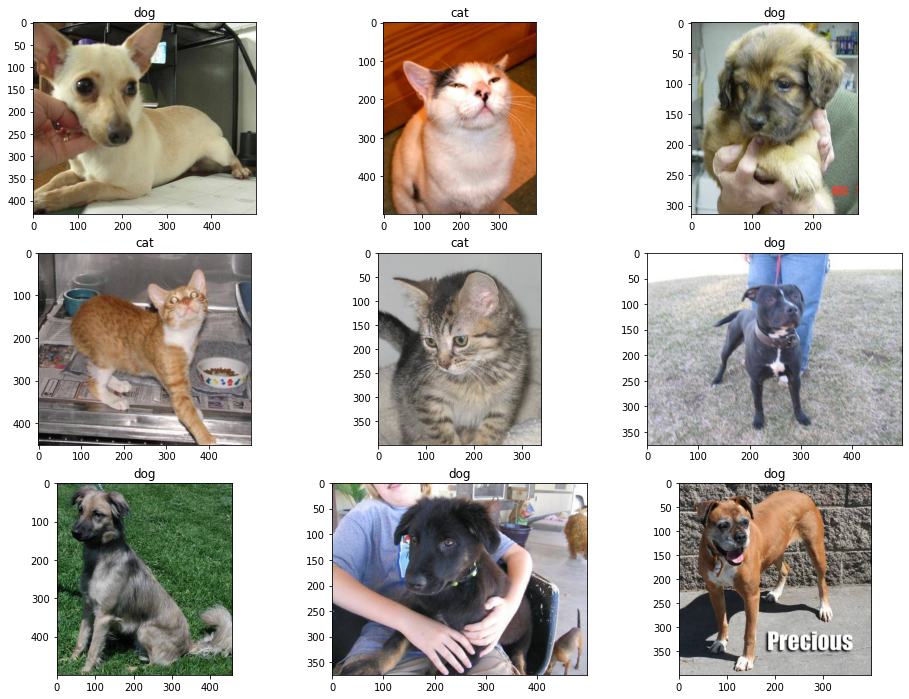

In [15]:
random_idx = np.random.randint(1, len(train_list), size=9)
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)

In [56]:
def visualize_model(model, num_images=9):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(test_loader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                ax.imshow(inputs.cpu().data[j].view(299, 299, 3))
                # plt.imshow(inputs.cpu().data[j].view(299, 299, 3)) #also tried this but similar wrong visualizations

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [17]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [18]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


In [19]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.RandomResizedCrop(299),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(299),
        transforms.CenterCrop(299),
        transforms.ToTensor(),
    ]
)

In [20]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("/")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label

In [21]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)


In [22]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [23]:
print(len(train_data), len(train_loader))

20000 1250


In [24]:
print(len(valid_data), len(valid_loader))

5000 313


In [25]:
import torchvision.models as models

model_ft = models.inception_v3(pretrained=True)
for param in model_ft.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
# Handle the auxilary net
num_ftrs = model_ft.AuxLogits.fc.in_features
model_ft.AuxLogits.fc = nn.Linear(num_ftrs, 2)
# Handle the primary net
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

In [26]:
! ls -ltrah /home/jalal/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth

-rw------- 1 jalal jalal 104M Mar  2 23:23 /home/jalal/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth


In [27]:
model_ft

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [28]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.Adam(model_ft.parameters(), lr=lr)
# scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [29]:
scheduler

In [30]:
model_ft.cuda()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [31]:
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in tqdm(train_loader):
        data = data.to(device)
        label = label.to(device)
        output , aux_output = model_ft(data)
        #output = torch.as_tensor(output)
        loss = criterion(output, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader)
        epoch_loss += loss / len(train_loader)

    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)
            val_output, aux_val_output = model_ft(data)
            val_loss = criterion(val_output, label)
            print('val preds: ', val_output.argmax(dim=1))
            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )


  0%|          | 0/1250 [00:00<?, ?it/s]

val preds:  tensor([0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1

val preds:  tensor([0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1

val preds:  tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0

val preds:  tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1

  0%|          | 0/1250 [00:00<?, ?it/s]

val preds:  tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0

val preds:  tensor([1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0

val preds:  tensor([0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1

val preds:  tensor([0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1

  0%|          | 0/1250 [00:00<?, ?it/s]

val preds:  tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0

val preds:  tensor([1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1

val preds:  tensor([1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1

val preds:  tensor([0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0

  0%|          | 0/1250 [00:00<?, ?it/s]

val preds:  tensor([0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0

val preds:  tensor([1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1

val preds:  tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0

val preds:  tensor([1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0

  0%|          | 0/1250 [00:00<?, ?it/s]

val preds:  tensor([1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 0

val preds:  tensor([0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0

val preds:  tensor([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1

val preds:  tensor([0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1], device='cuda:0')
val preds:  tensor([1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0], device='cuda:0')
val preds:  tensor([0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1], device='cuda:0')
val preds:  tensor([1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0], device='cuda:0')
val preds:  tensor([1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1], device='cuda:0')
val preds:  tensor([0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1], device='cuda:0')
val preds:  tensor([0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0

In [32]:
model_ft.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [33]:
! wget -O cat.jpg https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/cute-photos-of-cats-looking-at-camera-1593184780.jpg

--2022-03-03 12:05:11--  https://hips.hearstapps.com/hmg-prod.s3.amazonaws.com/images/cute-photos-of-cats-looking-at-camera-1593184780.jpg
Resolving webproxy.bu.edu (webproxy.bu.edu)... 128.197.228.95
Connecting to webproxy.bu.edu (webproxy.bu.edu)|128.197.228.95|:8900... connected.
Proxy request sent, awaiting response... 200 OK
Length: 412525 (403K) [image/jpeg]
Saving to: ‘cat.jpg’

cat.jpg             100%[===================>] 402.86K  --.-KB/s    in 0.02s   

2022-03-03 12:05:11 (18.5 MB/s) - ‘cat.jpg’ saved [412525/412525]



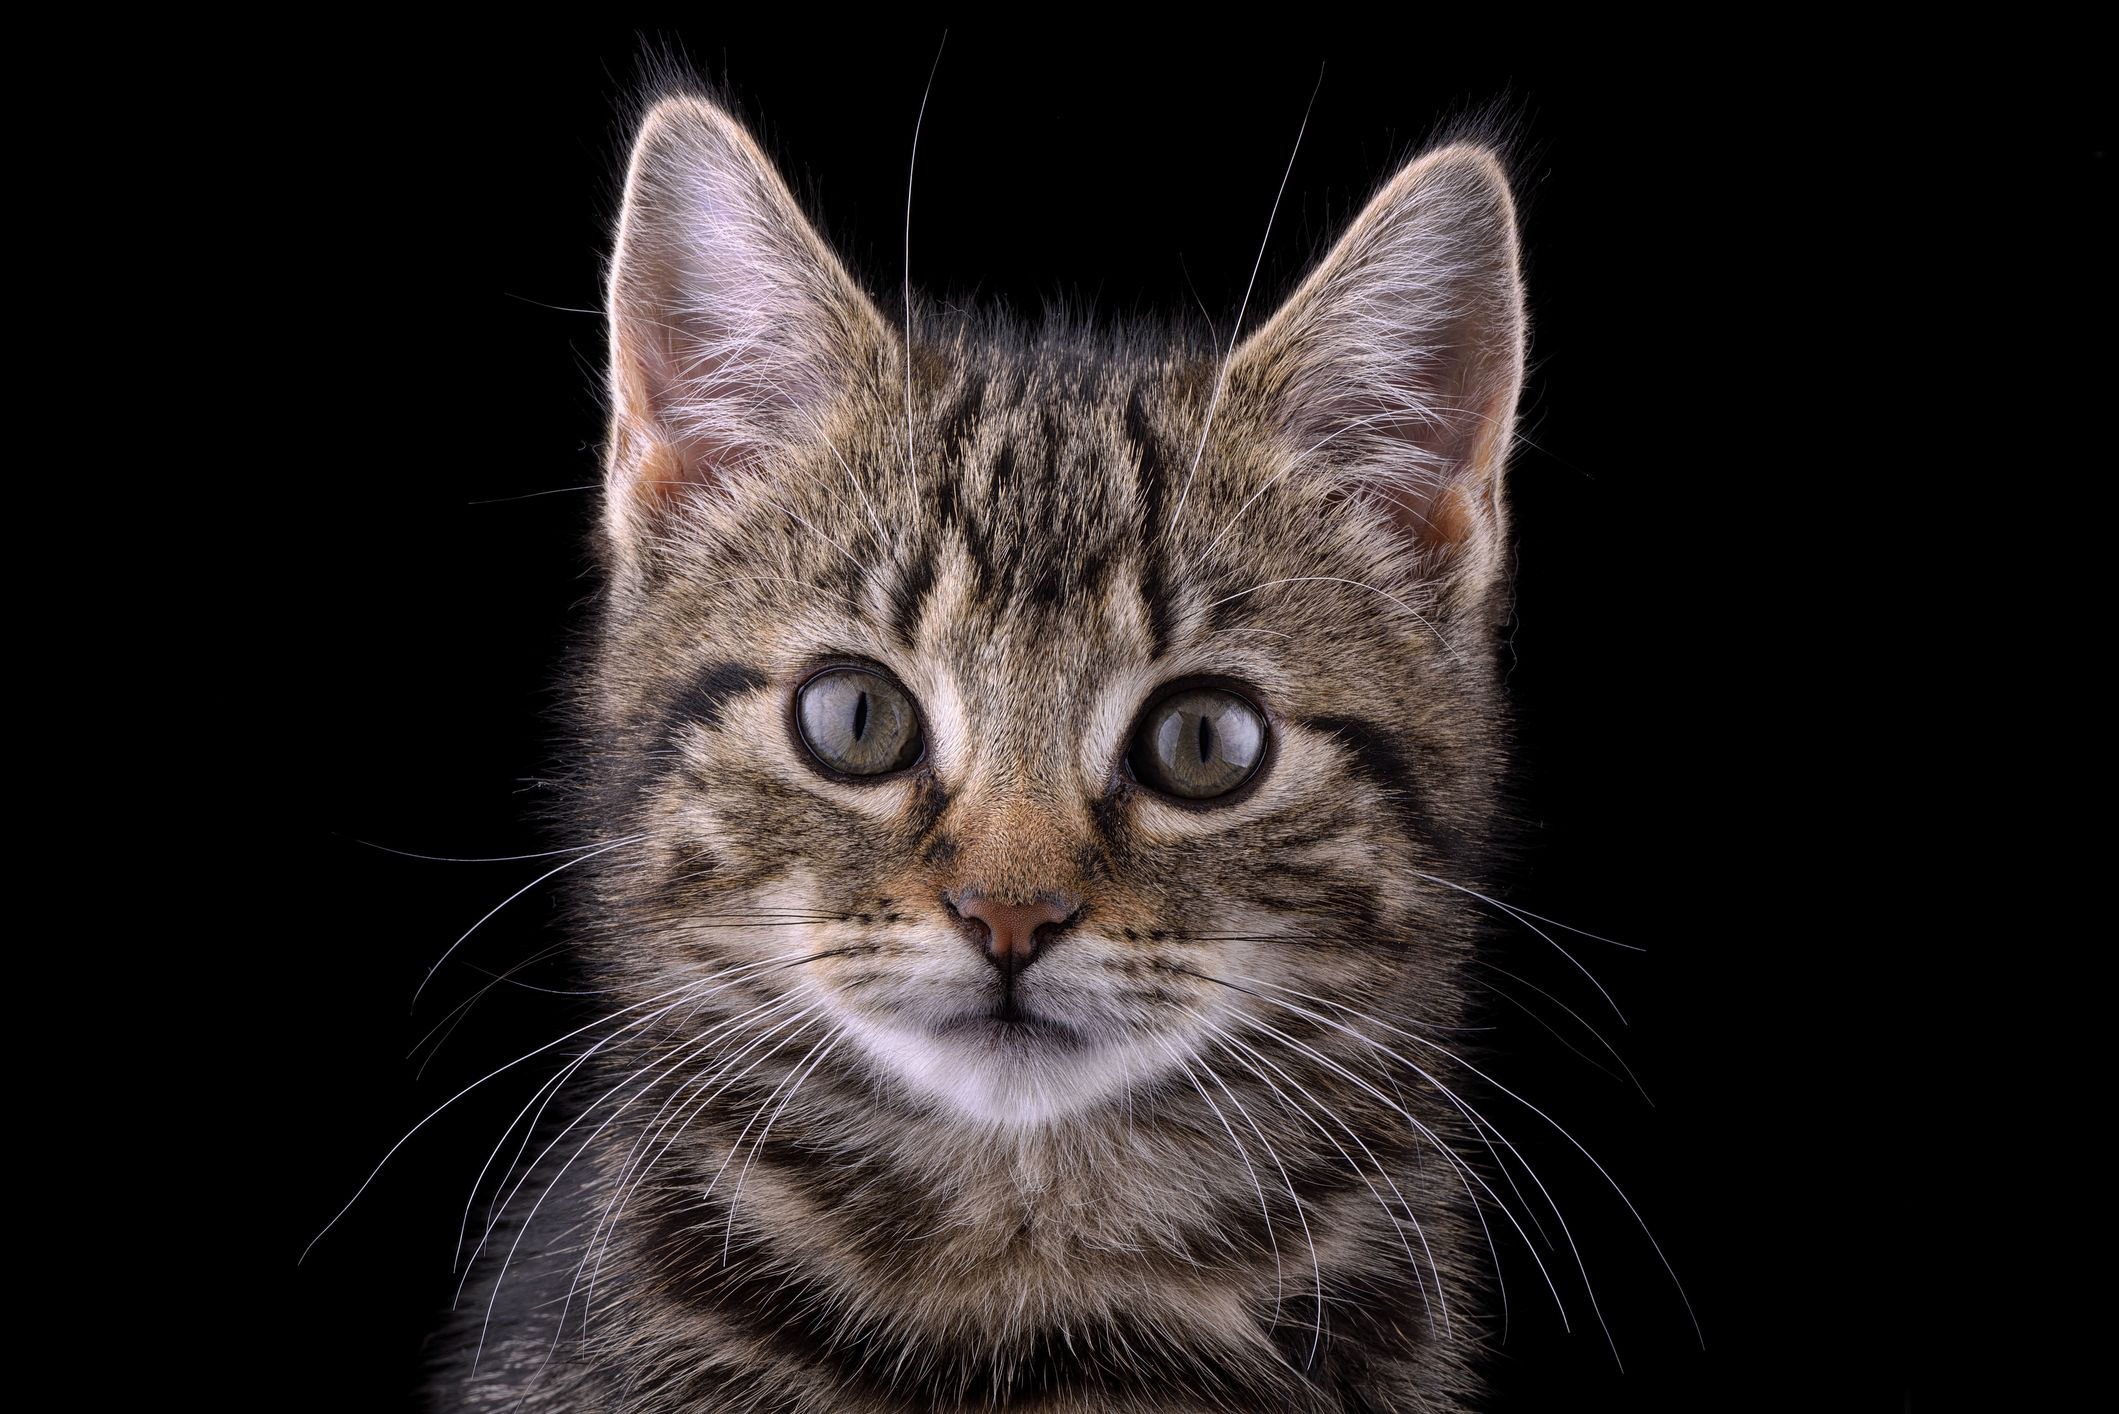

In [34]:
from PIL import Image

cat_img = Image.open('cat.jpg')
cat_img

In [35]:
cat_img_preprocessed = test_transforms(cat_img)

In [36]:
batch_img_cat_tensor = torch.unsqueeze(cat_img_preprocessed, 0)

In [37]:
out = model_ft(batch_img_cat_tensor.cuda())

In [38]:
out

tensor([[ 2.0370, -1.8205]], device='cuda:0', grad_fn=<AddmmBackward0>)

In [45]:
class_names = ['cat', 'dog']

ValueError: num must be 1 <= num <= 8, not 9

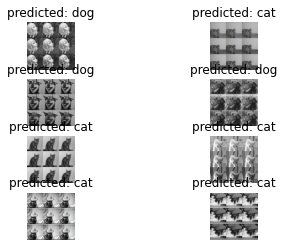

In [57]:
visualize_model(model_ft)